--- EDA 및 모델링 준비 스크립트 시작 ---
✅ Step 1: 'featured_data.csv' 로딩 성공!

--- Step 2: 탐색적 데이터 분석 (EDA) 시작 ---


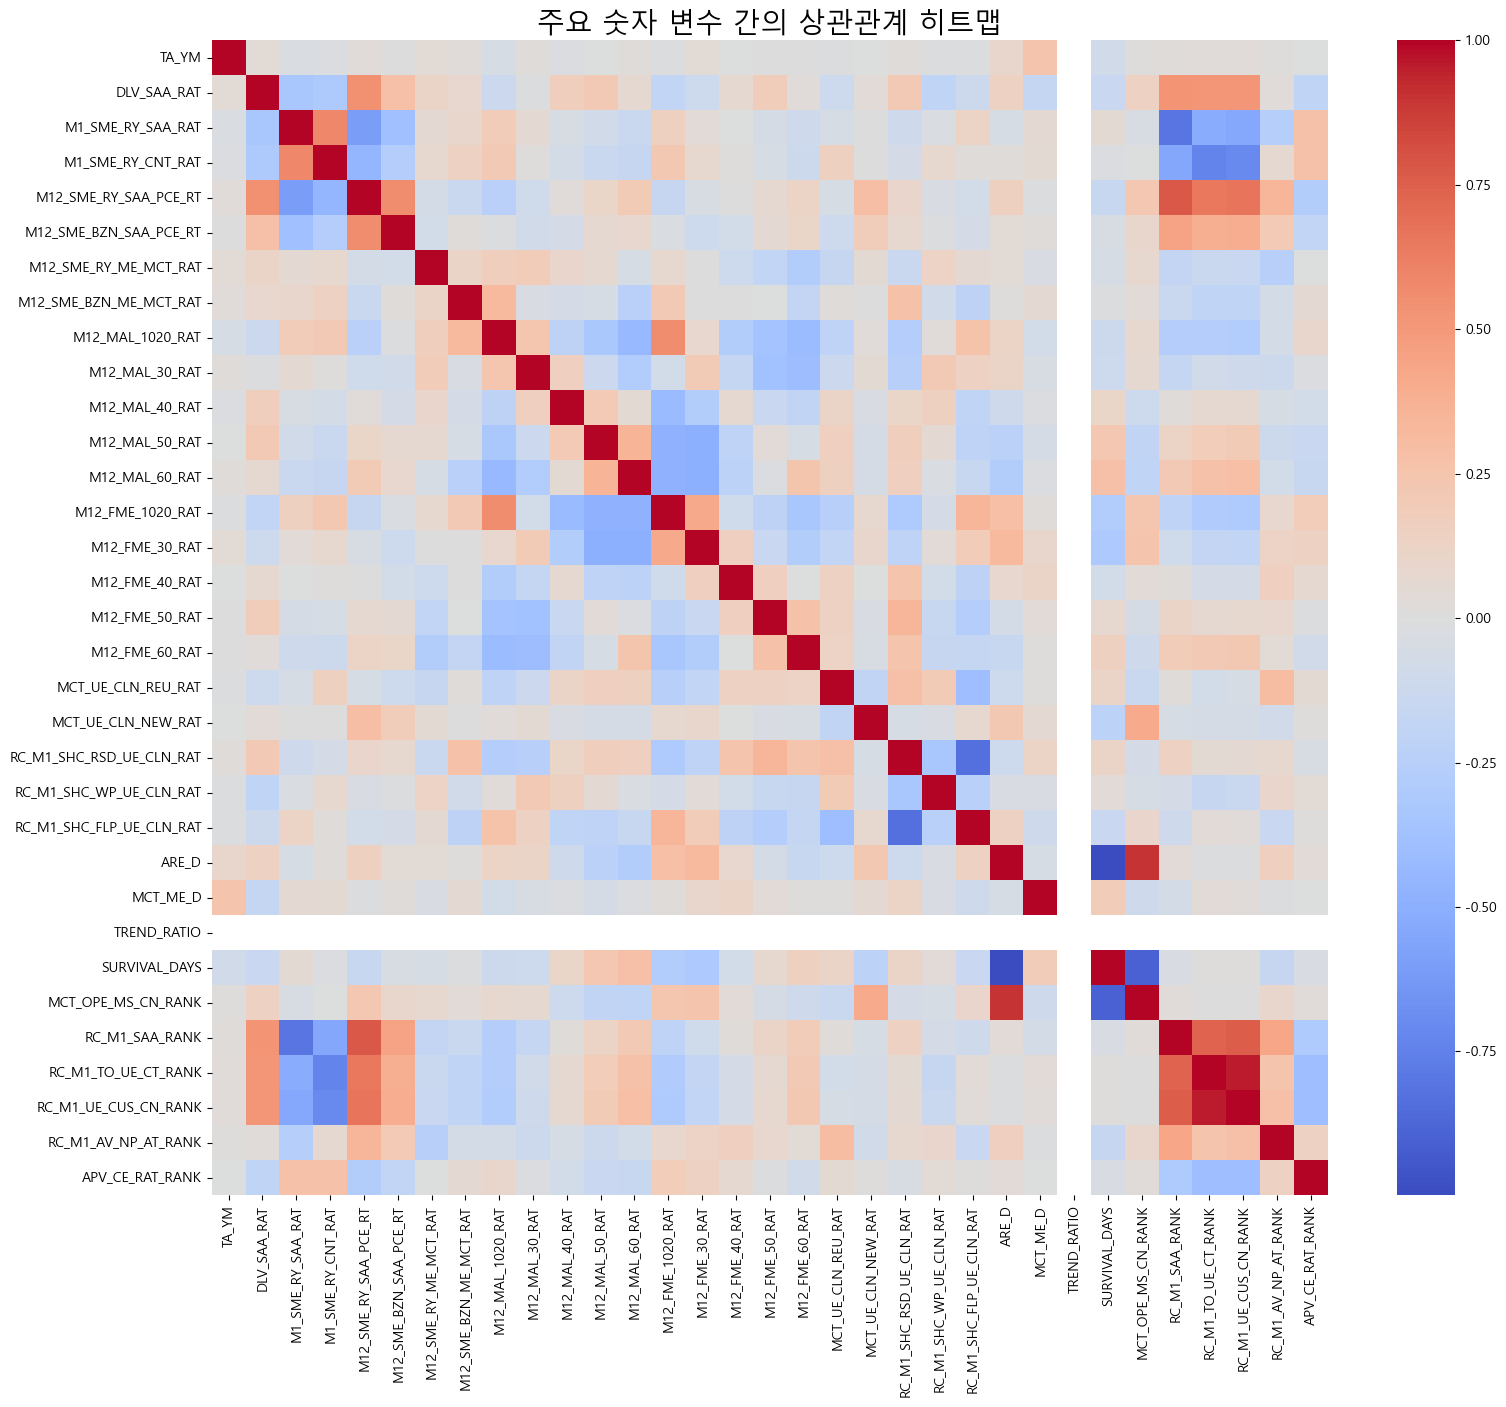

📊 (EDA 1) 상관관계 히트맵 출력 완료


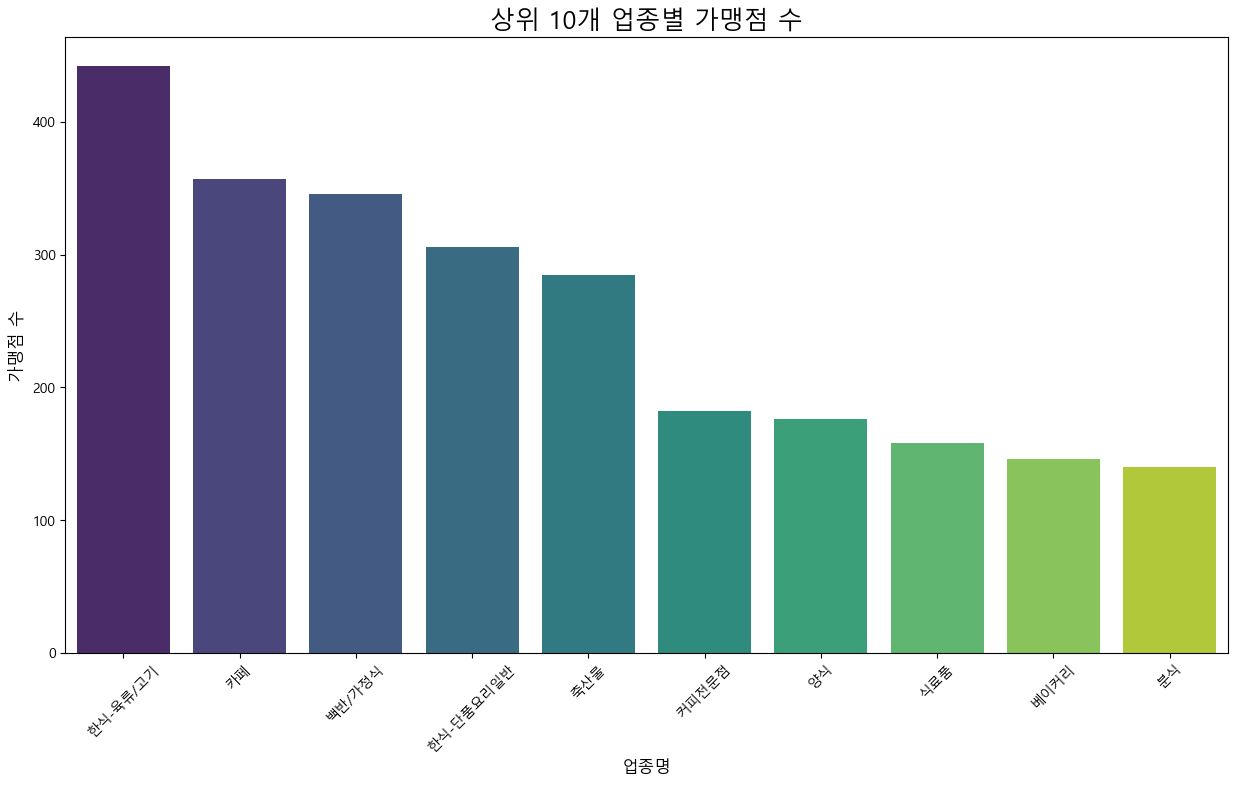

📊 (EDA 2) 업종별 가맹점 수 막대그래프 출력 완료

--- Step 3: 모델링용 최종 데이터셋 준비 완료 ---
✅ '가게' 단위의 고유 특징 데이터 생성 완료!
  - 최종 노드(가게) 수: 4185

--- 최종 노드 특징 데이터 샘플 ---
  ENCODED_MCT            MCT_BSE_AR HPSN_MCT_ZCD_NM  SURVIVAL_DAYS  \
0  000F03E44A   서울특별시 성동구 왕십리로4가길 9      중식-딤섬/중식만두           1040   
1  002816BA73    서울 성동구 청계천로10나길 78            요리주점           3891   
2  003473B465     서울특별시 성동구 서울숲길 55          백반/가정식           2065   
3  003AC99735  서울특별시 성동구 용답중앙15길 12           커피전문점           1902   
4  0041E4E5AE   서울특별시 성동구 용답중앙15길 1        한식-찌개/전골           2542   

   DLV_SAA_RAT  M1_SME_RY_SAA_RAT  M1_SME_RY_CNT_RAT  M12_SME_RY_SAA_PCE_RT  \
0    69.283333           1.683333           2.470833              92.650000   
1     0.000000         116.429167          53.708333              17.316667   
2     0.000000           1.062500           0.545833              86.183333   
3     1.500000         266.850000         487.162500               4.100000   
4     7.683333         211.200000        

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows, Mac 환경에 맞게 조절)
# 윈도우 사용자
plt.rcParams['font.family'] = 'Malgun Gothic'
# # 맥 사용자
# plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

print("--- EDA 및 모델링 준비 스크립트 시작 ---")

# ==============================================================================
# 1. 최종 데이터 불러오기
# ==============================================================================
try:
    # feature_engineering.ipynb에서 저장한 featured_data.csv 파일을 불러옵니다.
    # 이 노트북은 Processing 폴더 밖에 있다고 가정하고 경로를 설정합니다.
    df = pd.read_csv("featured_data.csv")
    print("✅ Step 1: 'featured_data.csv' 로딩 성공!")
except FileNotFoundError:
    print("❌ 오류: '../Processing/featured_data.csv' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    exit()

# ==============================================================================
# 2. 탐색적 데이터 분석 (EDA) - 데이터의 숨은 이야기 찾기
# ==============================================================================
print("\n--- Step 2: 탐색적 데이터 분석 (EDA) 시작 ---")

# (EDA 예시 1) 어떤 변수들이 서로 관련이 깊을까? - 상관관계 히트맵
# 숫자형 데이터만 선택하여 상관관계 행렬을 만듭니다.
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('주요 숫자 변수 간의 상관관계 히트맵', fontsize=20)
plt.show()

print("📊 (EDA 1) 상관관계 히트맵 출력 완료")

# (EDA 예시 2) 어떤 업종의 가게가 가장 많을까? - 업종별 가맹점 수
# 월별 데이터이므로, 고유한 가맹점 ID(ENCODED_MCT)를 기준으로 계산합니다.
plt.figure(figsize=(15, 8))
top_10_categories = df.drop_duplicates('ENCODED_MCT')['HPSN_MCT_ZCD_NM'].value_counts().nlargest(10)
sns.barplot(x=top_10_categories.index, y=top_10_categories.values, palette='viridis')
plt.title('상위 10개 업종별 가맹점 수', fontsize=18)
plt.xlabel('업종명', fontsize=12)
plt.ylabel('가맹점 수', fontsize=12)
plt.xticks(rotation=45)
plt.show()

print("📊 (EDA 2) 업종별 가맹점 수 막대그래프 출력 완료")


# ==============================================================================
# 3. 모델링을 위한 최종 데이터셋 준비
# ==============================================================================
# 프로젝트의 첫 번째 AI 모델인 VGAE는 각 '가게(가맹점)'의 특징을 학습합니다.
# 따라서 월별로 반복되는 데이터를 '가게' 단위로 집계(aggregate)하여
# 각 가게의 고유한 특징을 나타내는 데이터셋을 만듭니다.

# 3-1. 가게(Node)별 고정 정보 추출
# ENCODED_MCT를 기준으로 중복을 제거하고, 변하지 않는 정보들만 가져옵니다.
df_nodes = df.drop_duplicates('ENCODED_MCT')[['ENCODED_MCT', 'MCT_BSE_AR', 'HPSN_MCT_ZCD_NM', 'SURVIVAL_DAYS']].reset_index(drop=True)

# 3-2. 가게(Node)별 변동 정보(월별 데이터)를 평균값으로 집계
# 모델이 이해할 수 있도록 숫자형 데이터만 선택하여 평균을 냅니다.
numeric_cols_for_agg = df.select_dtypes(include=np.number).columns
# TA_YM, ARE_D, MCT_ME_D 등 집계가 무의미한 컬럼은 제외
cols_to_exclude = ['TA_YM', 'ARE_D', 'MCT_ME_D', 'SURVIVAL_DAYS']
cols_to_agg = [col for col in numeric_cols_for_agg if col not in cols_to_exclude]

df_agg = df.groupby('ENCODED_MCT')[cols_to_agg].mean().reset_index()

# 3-3. 고정 정보와 집계 정보를 병합하여 최종 노드 특징(Node Feature) 데이터 생성
df_node_features = pd.merge(df_nodes, df_agg, on='ENCODED_MCT', how='left')

# 결측치가 있다면 0으로 채워줍니다. (모델링 전 간단한 처리)
df_node_features = df_node_features.fillna(0)

print("\n--- Step 3: 모델링용 최종 데이터셋 준비 완료 ---")
print("✅ '가게' 단위의 고유 특징 데이터 생성 완료!")
print(f"  - 최종 노드(가게) 수: {len(df_node_features)}")
print("\n--- 최종 노드 특징 데이터 샘플 ---")
print(df_node_features.head())


# ==============================================================================
# 4. 최종 데이터셋 저장
# ==============================================================================
# 다음 단계인 그래프 생성 및 VGAE 모델링에서 바로 사용할 수 있도록 저장합니다.
output_path = "./node_features.csv"
df_node_features.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"\n🎉 모든 작업 완료! 그래프 모델링용 최종 데이터가 '{output_path}' 파일로 저장되었습니다.")